In [4]:
import math
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
try:
    import filterpy
except ImportError:
    !pip install filterpy
from filterpy.kalman import KalmanFilter, EnsembleKalmanFilter, UnscentedKalmanFilter, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise, Saver
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
plt.rcParams.update({'figure.max_open_warning': 0})

     |################################| 184kB 7.0MB/s eta 0:00:01
  Created wheel for filterpy: filename=filterpy-1.4.5-cp36-none-any.whl size=110452 sha256=e3180fee377d33e029947691391797caa11671452f57178fcdcfae9e760f5848
  Stored in directory: /home/wsuser/.cache/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
Successfully built filterpy


### Kalman filter models

In [5]:
def kalman_predictor(initial_state, kf_p, kf_r, kf_q, kf_a):
    """
    We model Covid development as a dynamical system composed of 3 components:
    - measurement (observable) = case count,
    - speed (latent) = growth rate (cases per day)
    - acceleration (latent) = growth acceleration (cases per day^2)    
    - used params of kf_p=0, kf_r=10, kf_q=20
    """
    # day is our observation interval
    dt = 1
    # transition matrix (x:measurement, v:growth rate, a:growth acceleration)
    F = np.array([[1, dt, 0.5*(dt**2)], # x_new           = x_old + v*dt + 1/2*a*dt^2
                    [0, 1, dt],           # d(v_new) / dt   = v     + a*dt + 0
                    [0, 0, 1]])           # d(x_new) / dt^2 = 0     + 0    + a
    '''
    F = np.array([[1, dt, (dt**2)/2, (dt**3)/6], # x_new = x_old + v*dt + 1/2*a*dt^2 + 1/6*j*dt^3
                  [0, 1, dt, (dt**2)/2],         # d(x_new) / dt = v + a*dt + 1/2*j*dt^2
                  [0, 0, 1, dt],                 # d(v_new) / dt = a + jt
                  [0, 0, 0, 1]])                 # d(a_new) / dt = j
    '''
    # define a linear KF with position, velocity, acceleration parameters
    dim_x = F.shape[0]
    kf = KalmanFilter(dim_x=dim_x, dim_z=1)
    kf.F = F
    # state vector: initial position, velocity, acceleration
    kf.x = np.zeros(dim_x)
    kf.x[0] = initial_state
    # measuremnet matrix: can only directly measure case counts, not velocity & acceleration
    kf.H = np.zeros((1, dim_x))
    kf.H[0][0] = 1
    # covariance matrix
    kf.P *= kf_p
    # measurement noise
    kf.R = kf_r
    # process noise
    kf.Q = Q_discrete_white_noise(dim=dim_x, dt=1, var=kf_q)
    # fading factor
    kf.alpha = kf_a
    return kf

def ensemble_kalman_predictor(initial_state, kf_p, kf_r, kf_q, kf_n):
    """
    We model Covid development as a dynamical system composed of 3 components:
    - measurement (observable) = case count,
    - speed (latent) = growth rate (cases per day)
    - acceleration (latent) = growth acceleration (cases per day^2)
    """
    # day is our observation interval
    dt = 1
    # transition matrix (x:measurement, v:growth rate, a:growth acceleration)
    F = np.array([[1, dt, (dt**2)/2], # x_new           = x_old + v*dt + 1/2*a*dt^2
                  [0, 1, dt],           # d(x_new) / dt   = v     + a*dt + 0
                  [0, 0, 1]])           # d(x_new) / dt^2 = 0     + 0    + a
    ''' also consider jerk
    F = np.array([[1, dt, (dt**2)/2, (dt**3)/6], # x_new = x_old + v*dt + 1/2*a*dt^2 + 1/6*j*dt^3
                  [0, 1, dt, (dt**2)/2],         # d(x_new) / dt = v + a*dt + 1/2*j*dt^2
                  [0, 0, 1, dt],                 # d(v_new) / dt = a + jt
                  [0, 0, 0, 1]])                 # d(a_new) / dt = j
    '''
    # state vector: initial position, velocity, acceleration
    X0 = np.zeros(F.shape[0])
    X0[0] = initial_state
    # transition function
    Fx = lambda x, dt: np.dot(F, x)
    # measuremnet function
    Hx = lambda x: np.array([x[0]])
    # covariance matrix
    P = np.eye(F.shape[0]) * kf_p
    # measurement noise
    R = kf_r
    # process noise
    Q = Q_discrete_white_noise(dim=F.shape[0], dt=1, var=kf_q)
    # let's make it
    kf = EnsembleKalmanFilter(x=X0, P=P, dim_z=1, dt=1, N=kf_n, hx=Hx, fx=Fx)
    kf.R = R
    kf.Q = Q
    return kf

### Forecast using Kalman filter

In [6]:
def kalman_forecast(series, days, kf_type, params):
    """
    Forecast based on history data.
    
    Input
    -----
    series: Pandas Series object with dates being index in ascending order.
    days: Prediction window length
    kf_type: linear, unscented, ensemble
    kf_*: Parameters for Kalman filter. Default values work reasonably well on several countries.
    
    Output
    ------
    Pandas DataFrame object with the following columns
    pred_raw: Raw prediction
    pred: Final prediction (with smoothing, etc.)
    ci_*: Lower and upper bounds of CI
    """
    if days <= 0:
        raise ValueError
    dates = series.index
    if kf_type == 'linear':
        if params is None:
            params = {'kf_p':1, 'kf_r':4, 'kf_q':0.1, 'kf_a':1}
        if params['kf_a'] < 1:
            raise ValueError
        kf = kalman_predictor(series[dates[0]], params['kf_p'], params['kf_r'], params['kf_q'], params['kf_a'])
    elif kf_type == 'ensemble':
        if params is None:
            params = {'kf_p':100, 'kf_r':1000, 'kf_q':0.1, 'kf_n':1000}
        kf = ensemble_kalman_predictor(series[dates[0]], params['kf_p'], params['kf_r'], params['kf_q'], params['kf_n'])
    else:
        raise NotImplementedError
    
    # fit model
    for measurement in series:
        kf.predict()
        kf.update([measurement])
    
    # start forecasting, starting from the last observation date
    last_date = dt.datetime.strptime(dates[-1], '%m-%d')
    predictions = [series[-1]]
    pred_dates = [dates[-1]]
    ci_bounds = [0]
    for day in range(days):
        future_date = (last_date + dt.timedelta(days=day+1)).strftime('%m-%d')
        pred_dates.append(future_date)
        kf.predict()
        predictions.append(kf.x[0])
        ci_bounds.append(kf_ci_bound(kf))
    
    # smoothen and add confidence intervals
    predictions = np.array(predictions)
    predictions[np.where(predictions < 0)[0]] = 0
    #smooth_buffer = list(series[dates[len(dates)-days+1:]])
    #predictions_smooth = smoother(smooth_buffer + predictions, days)[days-1:]
    predictions_smooth = smoother(predictions, days)
    ci_bounds = np.array(ci_bounds)
    ci_upper = predictions_smooth + ci_bounds
    ci_lower = predictions_smooth - ci_bounds
    ci_lower[np.where(ci_lower < 0)[0]] = 0
    
    df_pred = pd.DataFrame({'pred_raw':predictions, 'pred':predictions_smooth,
                          'ci_lower':ci_lower, 'ci_upper':ci_upper}, index=pred_dates)
    return df_pred

def kf_ci_bound(kf):
    """
    Compute 95% confidence interval from KF's positive semi-definite covariance matrix
    
    returns a positive single-sided boundary (half) of the interval
    -> CI = kf.x[0] +- kf_ci_bound(kf)
    """
    return 1.96 * (np.diag(kf.P)[0])**0.5

def smoother(x, winsize, method='slide'):
    if method == 'slide':
        x_smooth = []
        for i in range(len(x)):
            x_smooth.append(np.mean(x[max(0, i-winsize+1):i+1]))
    elif method == 'slide_recurse':
        x_smooth = predictions.copy()
        for i in range(len(x)):
            x_smooth[i] = np.mean(x_smooth[max(0, i-winsize):i+1])
    else:
        raise NotImplementedError
    assert(len(x) == len(x_smooth))
    return np.array(x_smooth)

### Helpers

In [7]:
def get_stats(observations, predictions):
    r2 = r2_score(observations, predictions)
    mae = mean_absolute_error(observations, predictions)
    rmse = mean_squared_error(observations, predictions) ** 0.5
    return r2, mae, rmse

def rescale(df_x):
    x = df_x.copy()
    x -= x.min()
    x /= x.max()
    return x

### Performance testing and debugging

In [8]:
def kalman_test(series, winsize, kf_type, params=None):
    """
    To test the performance compared with true values along all data points
    
    Input
    -----
    series: Pandas Series object with dates being index in ascending order.
    winsize: Prediction window size in number of days.
    kf_type: linear, unscented, ensemble
    kf_*: factors for Kalman filter. Default values work reasonably well.
          For long-term prediction, usually increasing the fading factor (kf_a) helps.
    
    Output
    ------
    Pandas DataFrame object with the following columns
    pred_raw: Raw prediction
    pred: Final prediction (with smoothing, etc.)
    obs: Ground-truth values
    history: recursive prediction history at each time point (for debugging purpose)
    """
    if winsize <= 0:
        raise ValueError
    observations = []
    predictions = []
    predictions_acc = []
    predictions_vel = []
    pred_dates = []
    history = []
    ci_bounds = []
    dates = series.index.to_numpy()
    if kf_type == 'linear':
        if params is None:
            params = {'kf_p':1, 'kf_r':4, 'kf_q':0.1, 'kf_a':1}
        if params['kf_a'] < 1:
            raise ValueError
        kf = kalman_predictor(series[dates[0]], params['kf_p'], params['kf_r'], params['kf_q'], params['kf_a'])
    elif kf_type == 'ensemble':
        if params is None:
            params = {'kf_p':100, 'kf_r':1000, 'kf_q':0.1, 'kf_n':1000}
        kf = ensemble_kalman_predictor(series[dates[0]], params['kf_p'], params['kf_r'], params['kf_q'], params['kf_n'])
    else:
        raise NotImplementedError(kf_type)
    
    for i in range(dates.shape[0]-winsize):
        # save the current state of the model
        saver = Saver(kf, skip_callable=True, save_current=True)
        
        # recursive prediction
        history_window = [kf.x[0]]
        date_window = [dates[i]]
        for day in range(winsize):
            kf.predict()
            history_window.append(kf.x[0])
            date_window.append(dates[i+day+1])
        history.append(pd.DataFrame({'pred':history_window}, index=date_window))
        pred_date = dates[i+winsize]
        pred_dates.append(pred_date)
        prediction = kf.x[0]
        predictions.append(prediction)
        predictions_vel.append(kf.x[1])
        predictions_acc.append(kf.x[2])
        observation = series[pred_date]
        observations.append(observation)
        ci_bounds.append(kf_ci_bound(kf))
        
        # restore model states and update to next day
        for attr in saver.keys:
            try:
                setattr(kf, attr, getattr(saver, attr)[-1])
            except AttributeError: # property decoration causes problem
                #print('.%s skip' % attr)
                continue
        kf.predict()
        kf.update([series[dates[i+1]]])
    
    # smoothen output
    predictions_smooth = smoother(predictions, winsize)
    predictions_smooth[predictions_smooth < 0] = 0
    #acc_smooth = smoother(predictions_acc, winsize)
    #vel_smooth = smoother(predictions_vel, winsize)
    acc_smooth = predictions_acc
    vel_smooth = predictions_vel
    ci_bounds = np.array(ci_bounds)
    ci_lower = predictions_smooth - ci_bounds
    ci_upper = predictions_smooth + ci_bounds
    ci_lower[np.where(ci_lower < 0)[0]] = 0
    df_pred = pd.DataFrame({'pred_raw':predictions[winsize:], 'pred':predictions_smooth[winsize:],
                          'obs':observations[winsize:], 'history':history[winsize:],
                          'ci_lower':ci_lower[winsize:], 'ci_upper':ci_upper[winsize:],
                          'pred_acc':acc_smooth[winsize:], 'pred_vel':vel_smooth[winsize:]},
                           index=pred_dates[winsize:])
    return df_pred

### Predict + plot functions

In [9]:
def test_plot(series, winsize, kf_type, params=None, title='', y_lims=None):
    """
    Make a prediction and plot at once for convenience.
    
    """
    PLOT_RAW = True
    SHOW_TRAJECTORY = True
    DO_FORECAST = False
    
    result = kalman_test(series, winsize, kf_type, params)
    if DO_FORECAST:
        forecast = kalman_forecast(series, winsize, kf_type, params)
    r2, mae, rmse = get_stats(result.obs, result.pred)
    #r2, mae, rmse = get_stats(result.obs, result.pred_raw)
    
    fig, ax = plt.subplots(3, 1, gridspec_kw={'height_ratios':[2,1,1]}, figsize=[13,8])
    
    # plot predictions and true values
    ax[0].plot(series.index, series, 'o', color='g', linewidth=3)
    ax[0].plot(result.index, result.pred, '-', color=(1,0,0,0.8), linewidth=3)
    if PLOT_RAW:
        ax[0].plot(result.index, result.pred_raw, 'o', color=(1,0,0,0.1), linewidth=3)
        if DO_FORECAST:
            ax[0].plot(forecast.index, forecast.pred_raw, 'o', color=(1,0,0,0.1), linewidth=3)
    ax[0].fill_between(result.index, result.ci_lower, result.ci_upper, color=(1,0,0,0.1))
    if DO_FORECAST:
        ax[0].plot(forecast.index, forecast.pred, color='r', linewidth=3)
        ax[0].fill_between(forecast.index, forecast.ci_lower, forecast.ci_upper, color=(1,0,0,0.1))
    if SHOW_TRAJECTORY:
        for df_h in result.history:
            ax[0].plot(df_h.index, df_h.pred, '-', color=(0,0,1,0.2))
    if y_lims:
        ax[0].set_ylim(y_lims)
    ax[0].tick_params(axis='x', labelrotation=45, labelsize='small')
    ax[0].set_title(r'%s ($r^2$:%.3f, mae:%d, rmse:%d=%.1f%% of global max %d)' % (title, r2, mae, rmse, rmse * 100 / series.max(), series.max()))
    ax[0].legend(['True', 'Prediction'])
    ax[0].grid(True, 'both')
    
    # plot growth rate
    ax[1].plot(series.index, [0] * len(series.index), 'k')
    if DO_FORECAST:    
        ax[1].plot(forecast.index, [0]*len(forecast.index), 'k')
    ax[1].plot(result.index, result.pred_vel, '-', color=(0,0,1,0.8), linewidth=3)
    ax[1].xaxis.set_ticklabels([])
    ax[1].grid(True, 'both')
    ax[1].set_title('Estimated growth rate')
    
    # plot growth acceleration
    ax[2].plot(series.index, [0]*len(series.index), 'k')
    if DO_FORECAST:
        ax[2].plot(forecast.index, [0]*len(forecast.index), 'k')
    ax[2].plot(result.index, result.pred_acc, '-', color=(0,0,1,0.8), linewidth=3)
    ax[2].xaxis.set_ticklabels([])
    ax[2].grid(True, 'both')
    ax[2].set_title('Estimated growth acceleration')
    
    plt.tight_layout()

In [10]:
def forecast_plot(series, winsize, kf_type, params=None, title='', y_lims=None):
    """
    Make a prediction and plot at once for convenience.    
    """
    PLOT_RAW = True
    
    forecast = kalman_forecast(series, winsize, kf_type, params)
    plt.figure(figsize=[13,5])
    plt.plot(series.index, series, 'o', color='g', linewidth=3)
    plt.plot(forecast.index, forecast.pred, '-', color=(1,0,0,0.9), linewidth=3)
    if PLOT_RAW:
        plt.plot(forecast.index, forecast.pred_raw, '.', color='r')
    plt.fill_between(forecast.index, forecast.ci_lower, forecast.ci_upper, color=(1,0,0,0.1))
    if y_lims:
        plt.ylim(y_lims)
    plt.xticks(rotation=45, fontsize='small')
    plt.title(title)
    plt.legend(['True', 'Prediction'])
    plt.grid(True, 'both')
    plt.tight_layout()

# Detect regions with sudden increase in infections

In [11]:
def detect_surge(series, thres):
    state = 0
    class result:
        time = []
        index = []
    for i, t in enumerate(series.index):
        if state == 0 and series.loc[t] >= thres:
            state = 1
            result.time.append(t)
            result.index.append(i)
        elif state == 1 and series.loc[t] < thres:
            state = 0
    return result

### South Korea

In [13]:
df_kr = pd.read_csv(r'/project_data/data_asset/TimeProvince.csv')
df_kr['active'] = df_kr['confirmed'] - df_kr['released'] - df_kr['deceased']
areas_kr = df_kr.province.unique()
print('%d provinces:\n' % len(areas_kr), areas_kr)
df_area_kr = df_kr.groupby(['province', 'date']).sum()
print('keys:\n', df_area_kr.columns)
df_area_kr.tail()

17 provinces:
 ['Seoul' 'Busan' 'Daegu' 'Incheon' 'Gwangju' 'Daejeon' 'Ulsan' 'Sejong'
 'Gyeonggi-do' 'Gangwon-do' 'Chungcheongbuk-do' 'Chungcheongnam-do'
 'Jeollabuk-do' 'Jeollanam-do' 'Gyeongsangbuk-do' 'Gyeongsangnam-do'
 'Jeju-do']
keys:
 Index(['time', 'confirmed', 'released', 'deceased', 'active'], dtype='object')


time  confirmed  released  deceased  active
province date                                                   
Ulsan    2020-06-26     0         55        49         1       5
         2020-06-27     0         55        50         1       4
         2020-06-28     0         55        50         1       4
         2020-06-29     0         55        50         1       4
         2020-06-30     0         55        50         1       4

Seoul(vel) ['2020-03-06', '2020-03-13', '2020-05-17', '2020-06-02'] Seoul(acc) ['2020-03-18', '2020-05-18'] 
Busan(vel) ['2020-03-03'] 
Daegu(vel) ['2020-02-24', '2020-04-06'] Daegu(acc) ['2020-02-24', '2020-04-07'] 
Incheon(vel) ['2020-06-04'] 
Gyeonggi-do(vel) ['2020-03-04', '2020-06-01'] 
Chungcheongnam-do(vel) ['2020-03-05'] Chungcheongnam-do(acc) ['2020-03-07'] 
Gyeongsangbuk-do(vel) ['2020-02-25'] Gyeongsangbuk-do(acc) ['2020-02-25'] 


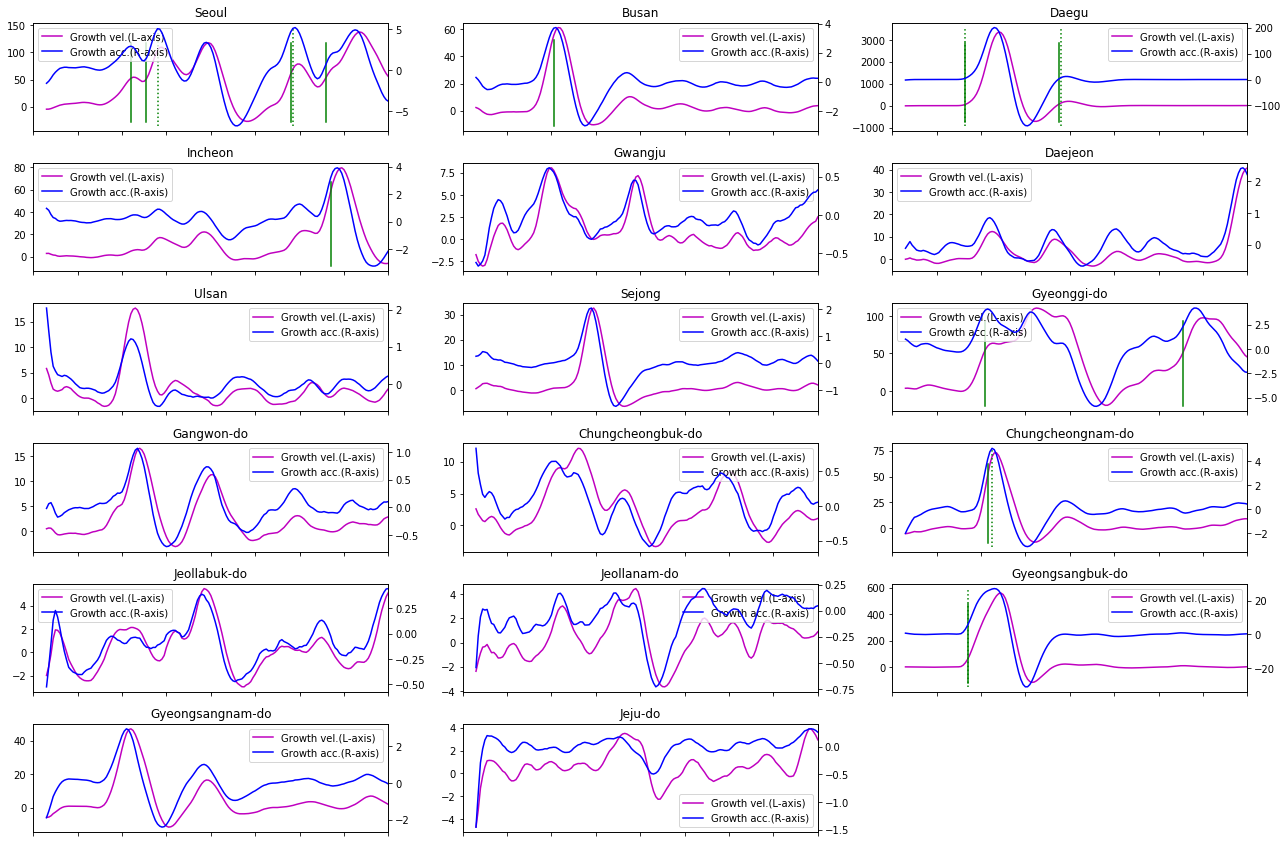

In [148]:
target = 'confirmed'
areas = areas_kr
df_area = df_area_kr

cols = 3
rows = math.ceil(len(areas) / cols)
plt.figure(figsize=[18, 2*rows])
n = 1
for area in areas:
    plt.subplot(rows, cols, n)
    series = df_area.loc[area,:][target]
    result = kalman_test(series, winsize=1, kf_type='ensemble', params=None)
    acc_smooth = result['pred_acc'].rolling(7, win_type='gaussian').sum(std=3)
    vel_smooth = result['pred_vel'].rolling(7, win_type='gaussian').sum(std=3)
    ax1 = vel_smooth.plot(style='m-', label='Growth vel.(L-axis)', legend=True)
    ax2 = acc_smooth.plot(style='b-', secondary_y=True, label='Growth acc.(R-axis)', mark_right=False, legend=True)
    #ax3 = series.plot(style='r-', label='Confirmed (L)', legend=True)
    surge_times_vel = detect_surge(vel_smooth, 50)
    surge_times_acc = detect_surge(acc_smooth, 5)
    if len(surge_times_vel.time) + len(surge_times_acc.time) > 0:
        ylims1 = np.array(ax1.get_ylim())
        for t in surge_times_vel.index:
            ax1.plot([t, t], ylims1*0.8, 'g-')
        for t in surge_times_acc.index:
            ax1.plot([t, t], ylims1, 'g:')
        if len(surge_times_vel.time) > 0:
            print('%s(vel)' % area, surge_times_vel.time, end=' ')
        if len(surge_times_acc.time) > 0:
            print('%s(acc)' % area, surge_times_acc.time, end=' ')
        print()
    plt.title(area)
    plt.tight_layout()
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    n += 1

### UK

In [18]:
df_uk = pd.read_csv('/project_data/data_asset/coronavirus-cases_latest.csv')
area_of_interest = 'Upper tier local authority'
df_area_uk = df_uk[df_uk['Area type'] == area_of_interest].sort_values('Specimen date')
areas_uk = df_area_uk['Area name'].unique()
df_area_uk = df_uk.groupby(['Area name', 'Specimen date']).sum()
df_area_uk.nunique()

Daily lab-confirmed cases                593
Previously reported daily cases          127
Change in daily cases                     19
Cumulative lab-confirmed cases          4683
Previously reported cumulative cases     145
Change in cumulative cases                39
Cumulative lab-confirmed cases rate     8514
dtype: int64

### Leicester case study

Leicester ['2020-06-19']


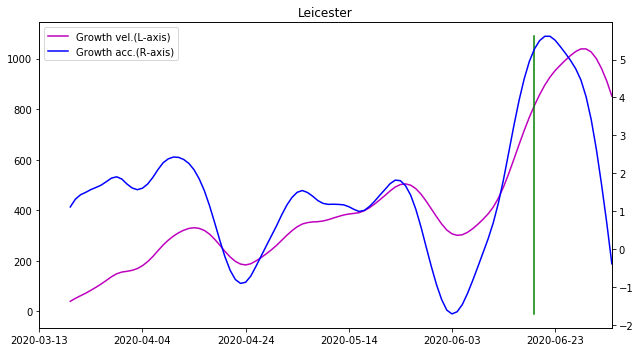

In [149]:
target = 'Cumulative lab-confirmed cases'
cols = 1
rows = math.ceil(len(areas_uk) / cols)
plt.figure(figsize=[9, 5])
area = 'Leicester'
series = df_area_uk.loc[area,:][target]
result = kalman_test(series, winsize=1, kf_type='ensemble', params=None)
acc_smooth = result['pred_acc'].rolling(7, win_type='gaussian').mean(std=3)
vel_smooth = result['pred_vel'].rolling(7, win_type='gaussian').sum(std=3)
ax1 = vel_smooth.plot(style='m-', label='Growth vel.(L-axis)', legend=True)
ax2 = acc_smooth.plot(style='b-', secondary_y=True, label='Growth acc.(R-axis)', mark_right=False, legend=True)
#ax3 = series.plot(style='r-', label='Confirmed (L)', legend=True)
surge_times = detect_surge(acc_smooth, thres=5)
print(area, surge_times.time)
for t in surge_times.index:
    ax1.plot([t, t], ax1.get_ylim(), 'g')
plt.title(area)
plt.tight_layout()

In [ ]:
target = 'Cumulative lab-confirmed cases'
areas = areas_uk
df_area = df_area_uk

cols = 3
rows = math.ceil(len(areas) / cols)
plt.figure(figsize=[18, 2*rows])
n = 1
for area in areas:
    plt.subplot(rows, cols, n)
    series = df_area.loc[area,:][target]
    result = kalman_test(series, winsize=1, kf_type='ensemble', params=None)
    acc_smooth = result['pred_acc'].rolling(7, win_type='gaussian').sum(std=3)
    vel_smooth = result['pred_vel'].rolling(7, win_type='gaussian').sum(std=3)
    ax1 = vel_smooth.plot(style='m-', label='Growth rate.(L-axis)', legend=True)
    ax2 = acc_smooth.plot(style='b-', secondary_y=True, label='Growth acc.(R-axis)', mark_right=False, legend=True)
    #ax3 = series.plot(style='r-', label='Confirmed (L)', legend=True)
    surge_times_vel = detect_surge(vel_smooth, 50)
    surge_times_acc = detect_surge(acc_smooth, 5)
    if len(surge_times_vel.time) + len(surge_times_acc.time) > 0:
        ylims1 = np.array(ax1.get_ylim())
        for t in surge_times_vel.index:
            ax1.plot([t, t], ylims1*0.8, 'g-')
        for t in surge_times_acc.index:
            ax1.plot([t, t], ylims1, 'g:')
        if len(surge_times_vel.time) > 0:
            print('%s(vel)' % area, surge_times_vel.time, end=' ')
        if len(surge_times_acc.time) > 0:
            print('%s(acc)' % area, surge_times_acc.time, end=' ')
        print()
    plt.title(area)
    plt.tight_layout()
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    n += 1

York(vel) ['2020-04-04'] York(acc) ['2020-04-07', '2020-04-27'] 
Kent(vel) ['2020-03-22'] Kent(acc) ['2020-03-26'] 
Barnsley(vel) ['2020-03-25'] Barnsley(acc) ['2020-03-25', '2020-05-04'] 
Devon(vel) ['2020-04-01'] Devon(acc) ['2020-04-05'] 
Hertfordshire(vel) ['2020-03-21', '2020-06-17'] Hertfordshire(acc) ['2020-03-24'] 
Brighton and Hove(vel) ['2020-03-28', '2020-05-30'] Brighton and Hove(acc) ['2020-04-02'] 
Leicestershire(vel) ['2020-03-25'] Leicestershire(acc) ['2020-03-27', '2020-04-25', '2020-05-24'] 
Oxfordshire(vel) ['2020-03-25'] Oxfordshire(acc) ['2020-03-30'] 
Lewisham(vel) ['2020-03-16'] Lewisham(acc) ['2020-03-15'] 
Worcestershire(vel) ['2020-03-23', '2020-05-18'] Worcestershire(acc) ['2020-03-26', '2020-04-21'] 
Ealing(vel) ['2020-03-16'] Ealing(acc) ['2020-03-16'] 
Enfield(vel) ['2020-03-15'] Enfield(acc) ['2020-03-14'] 
Hackney and City of London(vel) ['2020-03-15', '2020-05-08'] Hackney and City of London(acc) ['2020-03-14'] 
Bradford(vel) ['2020-03-26'] Bradford(acc

### France

In [141]:
df_regions = pd.read_csv('/project_data/data_asset/code-officiel-geographique-2019-regions-et-departement (1).csv', sep=';')
reg2name = {}
for reg in df_regions['Code INSEE Région'].unique():
    reg2name[reg] = df_regions[df_regions['Code INSEE Région']==reg]['Nom région'].iloc[0]
reg2name

{44: 'Grand Est',
 75: 'Nouvelle-Aquitaine',
 11: 'Île-de-France',
 1: 'Guadeloupe',
 53: 'Bretagne',
 24: 'Centre-Val de Loire',
 28: 'Normandie',
 4: 'La Réunion',
 84: 'Auvergne-Rhône-Alpes',
 93: "Provence-Alpes-Côte d'Azur",
 32: 'Hauts-de-France',
 3: 'Guyane',
 76: 'Occitanie',
 27: 'Bourgogne-Franche-Comté',
 94: 'Corse',
 52: 'Pays de la Loire',
 6: 'Mayotte',
 2: 'Martinique'}

In [142]:
df_fr = pd.read_csv('/project_data/data_asset/sp-pe-tb-quot-reg-2020-07-09-19h15.csv', sep = ";")
df_area_fr = df_fr.sort_values('jour')
areas_fr = sorted(df_area_fr['reg'].unique())
df_area_fr = df_fr.groupby(['reg', 'jour']).sum()
df_area_fr.head()

P_f  P_h  P     pop_f     pop_h       pop  cl_age90
reg jour                                                           
1   2020-05-13    0    0  0  411328.0  342430.0  753758.0       531
    2020-05-14    0    0  0  411328.0  342430.0  753758.0       531
    2020-05-15    0    0  0  411328.0  342430.0  753758.0       531
    2020-05-16    0    0  0  411328.0  342430.0  753758.0       531
    2020-05-17    0    0  0  411328.0  342430.0  753758.0       531

Detected clusters and onset dates
Guyane(vel) ['2020-05-27'] Guyane(acc) ['2020-05-27', '2020-06-10'] 
Mayotte(vel) ['2020-05-21', '2020-05-29'] Mayotte(acc) ['2020-05-21', '2020-05-31'] 
Île-de-France(vel) ['2020-05-21'] Île-de-France(acc) ['2020-05-21', '2020-07-06'] 
Centre-Val de Loire(vel) ['2020-05-21', '2020-06-19'] Centre-Val de Loire(acc) ['2020-05-21'] 
Bourgogne-Franche-Comté(vel) ['2020-05-21', '2020-06-11'] Bourgogne-Franche-Comté(acc) ['2020-05-21'] 
Normandie(vel) ['2020-05-21', '2020-06-14'] Normandie(acc) ['2020-05-21', '2020-06-19'] 
Hauts-de-France(vel) ['2020-05-21'] Hauts-de-France(acc) ['2020-05-21'] 
Grand Est(vel) ['2020-05-21'] Grand Est(acc) ['2020-05-21'] 
Pays de la Loire(vel) ['2020-05-21'] Pays de la Loire(acc) ['2020-05-21', '2020-07-05'] 
Bretagne(vel) ['2020-05-21', '2020-06-30'] Bretagne(acc) ['2020-05-21'] 
Nouvelle-Aquitaine(vel) ['2020-05-21', '2020-06-25'] Nouvelle-Aquitaine(acc) ['2020-05-21'] 
Occitanie(vel) ['2020-05-21', '2020-06-11'] Occitanie

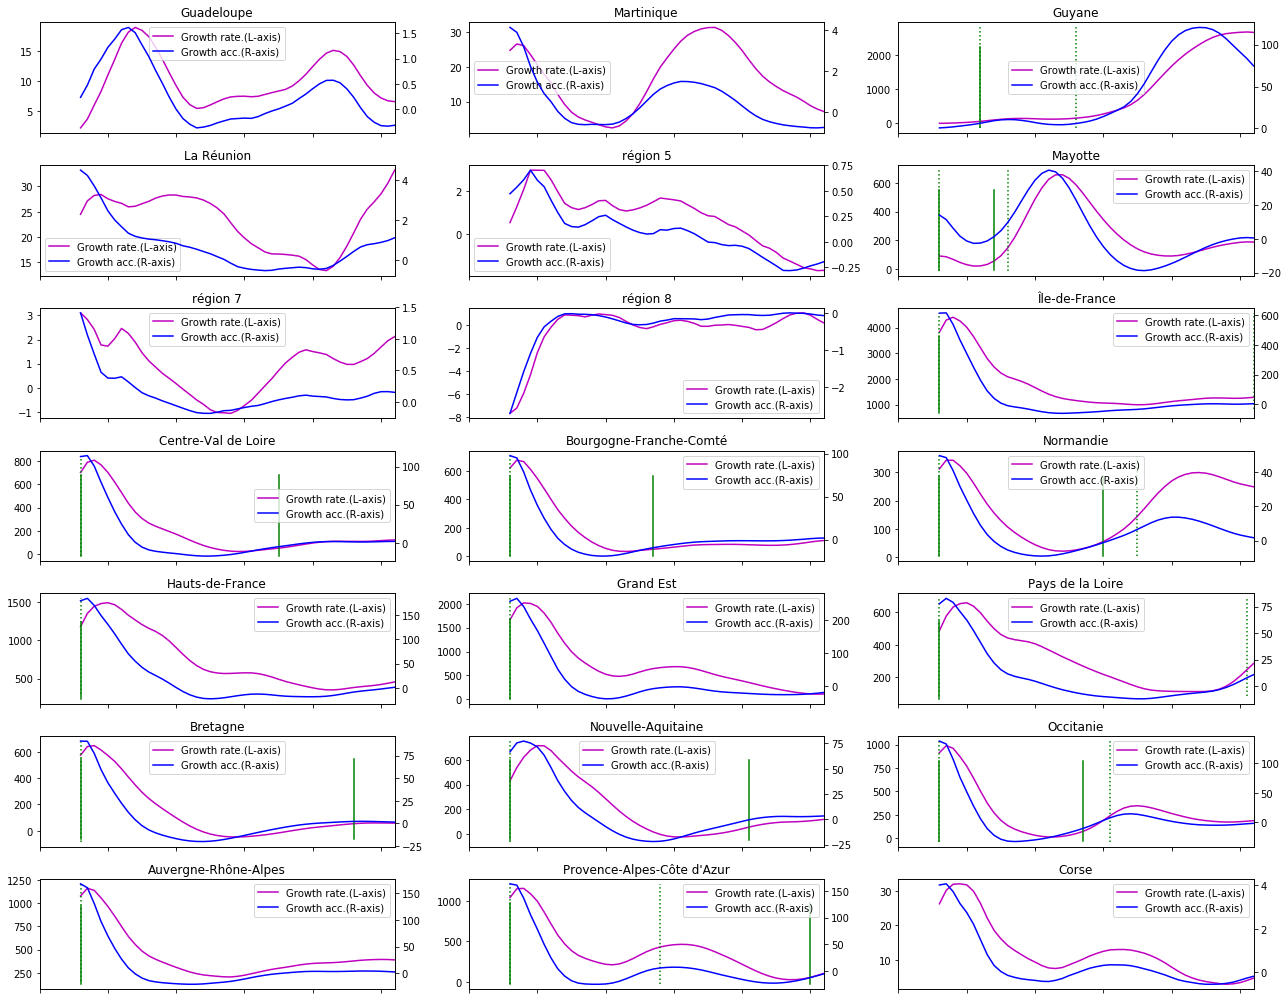

In [147]:
target = 'P'
areas = areas_fr
df_area = df_area_fr

cols = 3
rows = math.ceil(len(areas) / cols)
plt.figure(figsize=[18, 2*rows])
n = 1
print('Detected clusters and onset dates')
for area in areas:
    plt.subplot(rows, cols, n)
    series = df_area.loc[area,:][target].cumsum()
    result = kalman_test(series, winsize=1, kf_type='ensemble', params=None)
    acc_smooth = result['pred_acc'].rolling(7, win_type='gaussian').sum(std=3)
    vel_smooth = result['pred_vel'].rolling(7, win_type='gaussian').sum(std=3)
    ax1 = vel_smooth.plot(style='m-', label='Growth rate.(L-axis)', legend=True)
    ax2 = acc_smooth.plot(style='b-', secondary_y=True, label='Growth acc.(R-axis)', mark_right=False, legend=True)
    #ax3 = series.plot(style='r-', label='Confirmed (L)', legend=True)
    surge_times_vel = detect_surge(vel_smooth, 50)
    surge_times_acc = detect_surge(acc_smooth, 5)
    try:
        area_name = reg2name[area]
    except KeyError:
        area_name = 'région %d' % area
    if len(surge_times_vel.time) + len(surge_times_acc.time) > 0:
        ylims1 = np.array(ax1.get_ylim())
        for t in surge_times_vel.index:
            ax1.plot([t, t], ylims1*0.8, 'g-')
        for t in surge_times_acc.index:
            ax1.plot([t, t], ylims1, 'g:')
        if len(surge_times_vel.time) > 0:
            print('%s(vel)' % area_name, surge_times_vel.time, end=' ')
        if len(surge_times_acc.time) > 0:
            print('%s(acc)' % area_name, surge_times_acc.time, end=' ')
        print()
    plt.title(area_name)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.tight_layout()
    n += 1
print('\n\n         -- Onset times based on growth rate (green solid line) and based on growth acceleration (green dotted line) --')
